# LOESS Trend Analysis

In [1]:
from pathlib import Path
from functools import cache

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mgplot as mg
from statsmodels.nonparametric.smoothers_lowess import lowess  # type: ignore[import-untyped]
from IPython.display import display

from common import RFOOTER

LFOOTER = "Australia. Polling data sourced from Wikipedia. "
SHOW_PLOT = True

In [2]:
# Set up plotting directory
mg.set_chart_dir("../charts/LOESS-trend/")
mg.clear_chart_dir()

## Upload the data

In [3]:
def load_polling_data() -> pd.DataFrame:
    """Load the most recent polling data with data freshness validation."""
    today = pd.Timestamp.now().strftime("%Y-%m-%d")
    data_dir = Path("../poll-data")

    # Look for today's file first
    today_file = data_dir / f"voting_intention_next_{today}.csv"
    fallback_file = data_dir / "voting_intention_next.csv"

    if today_file.exists():
        data_path = today_file
        print(f"Using today's data file: {data_path}")
    else:
        # Look for any recent file with date suffix
        pattern = "voting_intention_next_*.csv"
        recent_files = list(data_dir.glob(pattern))

        help = "Consider running the scraper first: automated/scrape_wikipedia_polls.py"
        if recent_files:
            # Sort by filename (date suffix) and take most recent
            most_recent = sorted(recent_files)[-1]
            file_date = most_recent.stem.split("_")[-1]  # Extract date from filename

            print(f"⚠️  WARNING: No data file found for today ({today})")
            print(f"Using most recent file: {most_recent} (from {file_date})")
            print(help)
            data_path = most_recent
        elif fallback_file.exists():
            print("⚠️  WARNING: No dated data files found")
            print(f"Using fallback file: {fallback_file}")
            print(help)
            data_path = fallback_file
        else:
            raise FileNotFoundError(
                "No polling data files found. Please run the scraper first: python scrape_wikipedia_polls.py"
            )

    # Load the data
    df = pd.read_csv(data_path)
    df.index = pd.PeriodIndex(df["parsed_date"], freq="D")

    df = df.dropna(axis=1, how="all")  # drop all NAN columns

    return df


data = load_polling_data()

Using today's data file: ../poll-data/voting_intention_next_2025-10-02.csv


### Data Preview

In [4]:
def preview_polling_data(data: pd.DataFrame) -> None:
    """Display a preview of the polling data."""
    display(data.head(10))


# Show the data preview
preview_polling_data(data)

,Date,Brand,Interview mode,Sample size,Primary vote ALP,Primary vote L/NP,Primary vote GRN,Primary vote ONP,Primary vote IND,Primary vote OTH,2PP vote ALP,2PP vote L/NP,parsed_date,problematic
parsed_date,,,,,,,,,,,,,,
2025-09-30,30 Sep 2025,Essential,Online,1000,37.234043,28.723404,11.702128,13.829787,NaN,8.510638,53.684211,46.315789,2025-09-30,False
2025-09-07,25 Aug – 21 Sep 2025,Roy Morgan,Online,5084,34.000000,30.000000,12.000000,9.500000,NaN,14.500000,55.500000,44.500000,2025-09-07,False
2025-09-11,9 – 13 Sep 2025,Resolve,Telephone/Online,1800,35.000000,27.000000,11.000000,12.000000,9.0,6.000000,55.000000,45.000000,2025-09-11,False
2025-09-09,8 – 11 Sep 2025,Newspoll,Online,1283,36.000000,27.000000,13.000000,10.000000,NaN,14.000000,58.000000,42.000000,2025-09-09,False
2025-08-29,19 Aug – 8 Sep 2025,Redbridge,Online,5326,35.000000,30.000000,11.000000,11.000000,NaN,13.000000,53.500000,46.500000,2025-08-29,False
2025-08-10,28 Jul – 24 Aug 2025,Roy Morgan,Online,5001,34.000000,30.000000,12.000000,9.000000,NaN,15.000000,56.500000,43.500000,2025-08-10,False
2025-08-13,11–15 Aug 2025,Resolve,Telephone/Online,1800,37.000000,29.000000,12.000000,9.000000,8.0,6.000000,59.000000,41.000000,2025-08-13,False
2025-08-12,11–14 Aug 2025,Newspoll,Online,1283,36.000000,30.000000,12.000000,9.000000,NaN,13.000000,56.000000,44.000000,2025-08-12,False
2025-07-24,18–30 Jul 2025,Wolf & Smith,—,5000,36.000000,30.000000,NaN,NaN,NaN,NaN,57.000000,43.000000,2025-07-24,True


### Any problematic?

In [5]:
# Check for any problematic entries as identified by the scraper
data.loc[data.problematic]

,Date,Brand,Interview mode,Sample size,Primary vote ALP,Primary vote L/NP,Primary vote GRN,Primary vote ONP,Primary vote IND,Primary vote OTH,2PP vote ALP,2PP vote L/NP,parsed_date,problematic
parsed_date,,,,,,,,,,,,,,
2025-07-24,18–30 Jul 2025,Wolf & Smith,—,5000,36.0,30.0,NaN,NaN,NaN,NaN,57.0,43.0,2025-07-24,True


## Establish 2025 Election benchmarks

In [6]:
COALITION_LIST = ["LP", "LNP", "NP", "CLP"]
OTHER_LIST = ["DLP", "DEM", "UAP", "Others"]
COALITION = "Coalition"
OTHER = "Other"

@cache
def get_last_election() -> pd.Series:
    """Retrieve the latest election results for annotations."""    

    # Capture latest value for 2025 election annotations
    election_df = pd.read_csv(
        "../historic-data/election-outcomes.csv",
        sep=' ',
        skipinitialspace=True,
        header=0,
        comment='#',
        na_values=["", "-"],
    ).fillna(0)  # make sure NA values are 0 for numeric addition

    # Convert all columns to numeric where possible
    for col in election_df.columns:
        try:
            election_df[col] = pd.to_numeric(election_df[col])
        except ValueError:
            continue

    # only keep numeric columns and filter for 2025 election results
    df_numeric = election_df.select_dtypes(include=['number'])
    election_2025 = df_numeric[df_numeric["Year"] == 2025].iloc[0]

    # Calculate Coalition and Others totals
    election_2025[COALITION] = election_2025[COALITION_LIST].sum()
    election_2025[OTHER] = election_2025[OTHER_LIST].sum()

    # Clean up to keep only relevant fields
    election_2025.drop(labels=["Year"]+COALITION_LIST+OTHER_LIST, inplace=True)

    return election_2025


e25 = get_last_election()
print("2025 Election results for annotation:\n", e25)
print("Primary vote check (should be 100%): ",
      e25[COALITION] + e25["ALP"] + e25["GRN"] + e25["ON"] + e25[OTHER])

2025 Election results for annotation:
 ALP          34.56
GRN          12.20
ON            6.40
Labor2pp     55.22
Coalition    31.82
Other        15.02
Name: 30, dtype: float64
Primary vote check (should be 100%):  100.0


## LOESS Smoothing

In [7]:
def create_loess_smoothing(data: pd.DataFrame, column: str, day_span=90) -> pd.Series:
    """Create LOESS smoothing and return smoothed data."""
    # Sort by index (PeriodIndex) instead of 'date' column to avoid ambiguity
    df_2pp_sorted = data.sort_index().copy()

    # Apply LOESS smoothing
    series = df_2pp_sorted[column].dropna()
    dates_as_ordinals = [p.ordinal for p in series.index]
    denominator = np.max(dates_as_ordinals) - np.min(dates_as_ordinals)
    fraction = day_span / denominator if denominator else 1
    fraction = fraction if fraction < 1 else 1
    smoothed = lowess(
        df_2pp_sorted[column].dropna(),
        dates_as_ordinals,
        frac=fraction,  # Smoothing parameter - adjust as needed
    )
    smoothed_series = pd.Series(smoothed[:, 1], index=series.index)
    smoothed_series.name = f"LOESS {day_span}-day smoothing"
    smoothed_series = smoothed_series[~smoothed_series.index.duplicated(keep="first")]

    return smoothed_series

In [8]:
def create_chart_with_loess(
    df_2pp: pd.DataFrame,
    smoothed: pd.Series,
    color: str,
    name: str,
    col: str,
    f: str = "",
) -> None:
    """Create and display the LOESS chart with polling data."""

    _fig, ax = plt.subplots()
    symbols = ["o", "s", "^", "v", "<", ">", "D", "x", "v"]
    for i, label in enumerate(sorted(df_2pp["Brand"].unique())):
        selection = df_2pp[df_2pp["Brand"] == label][col]
        if selection.empty or selection.isna().all():
            continue
        x = [p.ordinal for p in selection.index]
        y = selection.to_numpy()
        ax.scatter(
            x, y, label=label, color=color, s=20, marker=symbols[i % len(symbols)]
        )
    
    # Map column names to the 2025 election results
    prev_election = get_last_election()
    results_map = {
        "2PP vote ALP": prev_election["Labor2pp"],
        "2PP vote L/NP": 100 - prev_election["Labor2pp"],
        "Primary vote ALP": prev_election["ALP"],
        "Primary vote L/NP": prev_election[COALITION],
        "Primary vote GRN": prev_election["GRN"],
        "Primary vote ONP": prev_election["ON"],
        "Others Primary Vote": prev_election[OTHER],
    }
    
    # Add a horizontal line for 2025 election result if available
    if col in results_map:
        result = results_map[col]
        ax.axhline(y=result, color=color, linestyle="--", alpha=0.6, linewidth=2.0,
                   label=f"2025 Result: {result:.1f}%")

    mg.line_plot_finalise(
        smoothed,
        ax=ax,
        title=f"{name} - {col} - Trend",
        xlabel=None,
        ylabel=f"{col} (%)",
        legend=True,
        width=2.5,
        color=color,
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER} {f} n={len(df_2pp[col].dropna())} polls. ".replace("  ", " ").replace("  ", " "),
        show=SHOW_PLOT,
    )

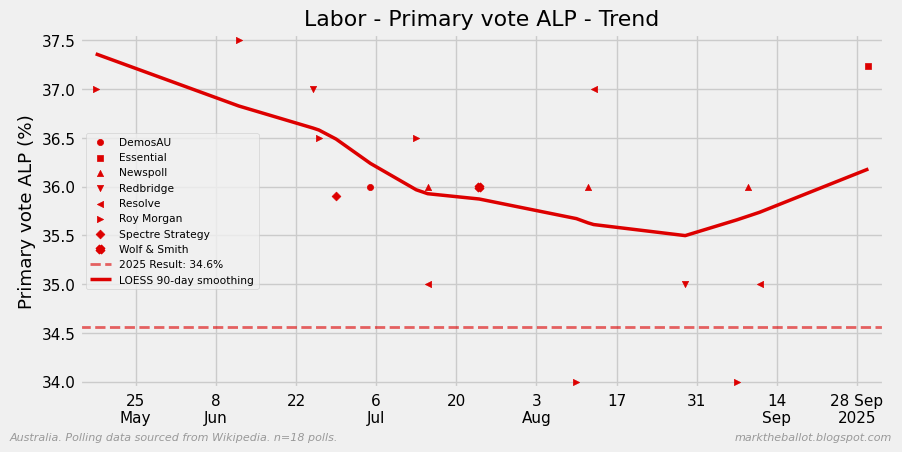

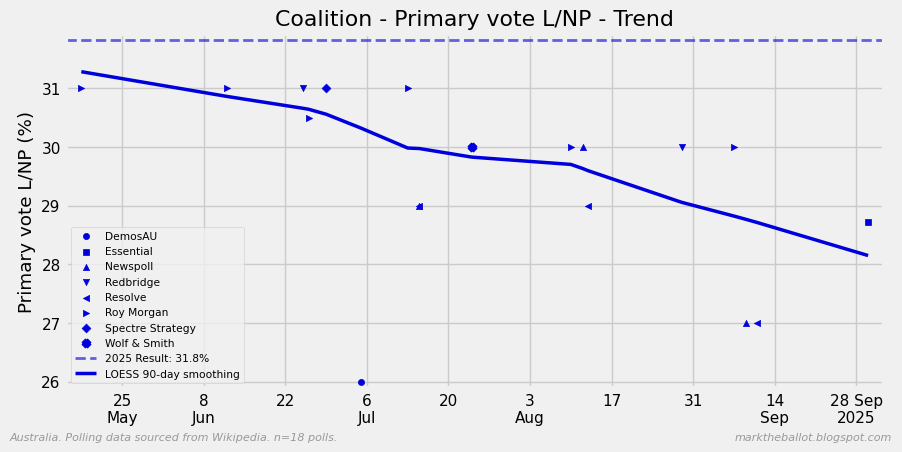

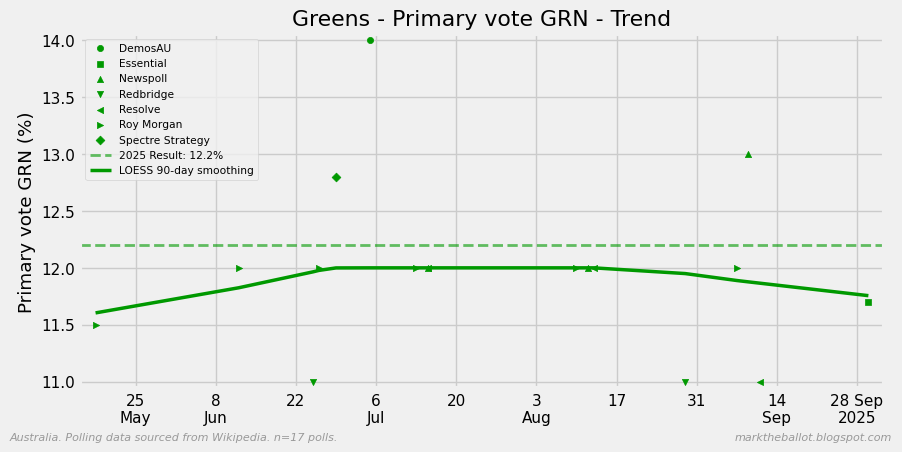

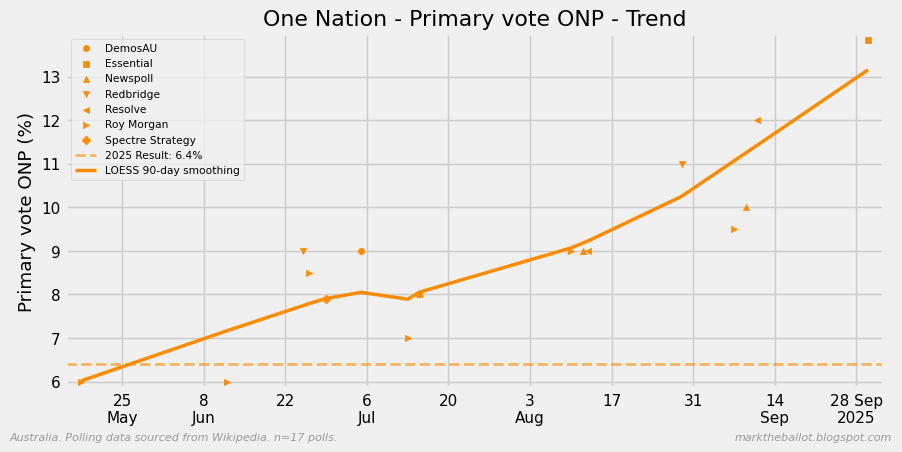

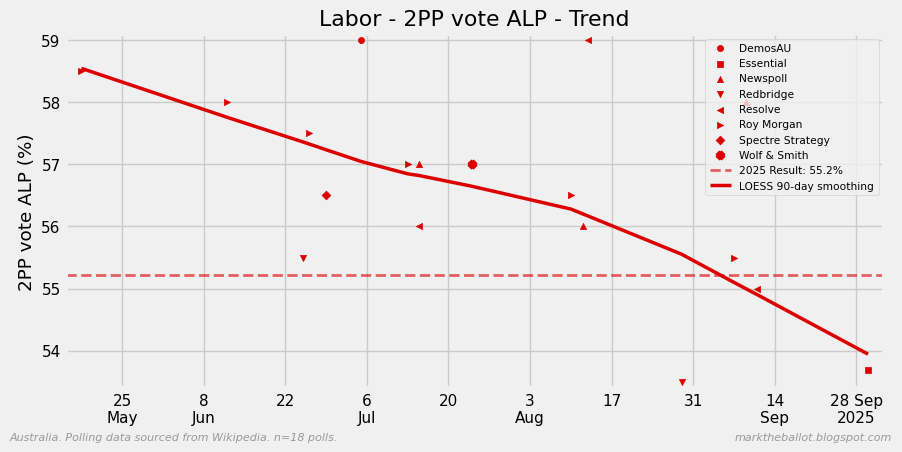

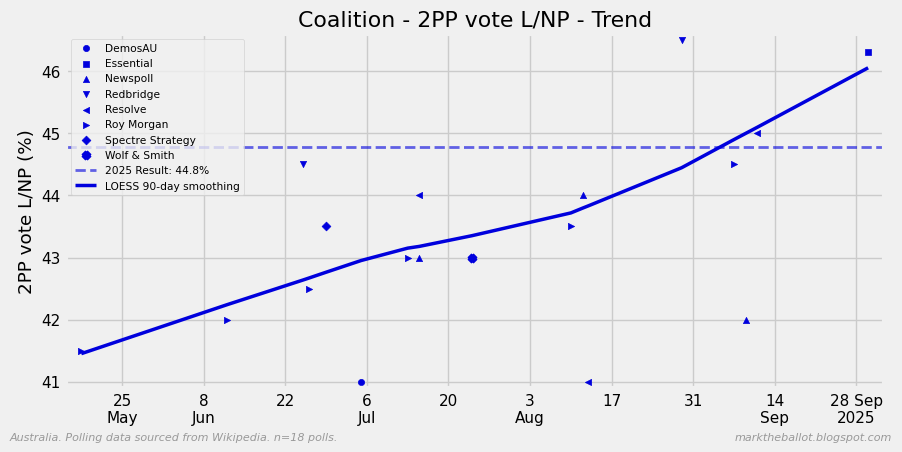

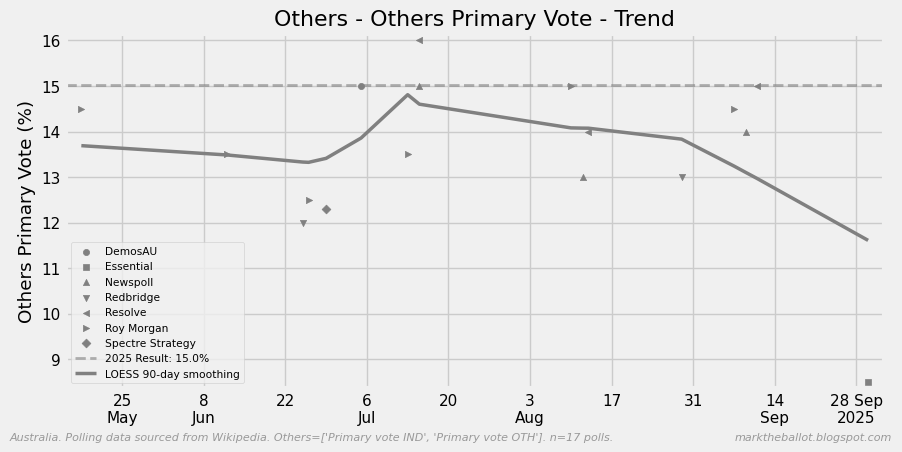

In [9]:
wanted = {
    # party: [name, color]
    "ALP": ["Labor", "#dd0000"],
    "L/NP": ["Coalition", "#0000dd"],
    "GRN": ["Greens", "#009900"],
    "ONP": ["One Nation", "darkorange"],
}
used = []
for col in data.columns:
    if "vote" not in col:
        continue
    for w in wanted:
        if w in col:
            used.append(col)
            name, color = wanted[w]
            smoothed = create_loess_smoothing(data, col)
            create_chart_with_loess(
                data,
                smoothed,
                color,
                name,
                col,
            )

# Create chart for "Others Primary Vote"
remaining = [w for w in data.columns if w not in used and "vote" in w]
col = "Others Primary Vote"
data[col] = data[remaining].sum(axis=1, skipna=True)
problematic = data[remaining].isna().all(axis=1)
data.loc[problematic, col] = np.nan  # Ensure problematic rows are NaN
smoothed = create_loess_smoothing(data, col)
create_chart_with_loess(
    data, smoothed, "grey", "Others", col, f=f"Others={remaining}. "
)

## Finished

In [10]:
%load_ext watermark
%watermark -t -d -u --python --machine --conda --iversions --watermark

Last updated: 2025-10-02 08:58:17

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.0.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

statsmodels: 0.14.5
matplotlib : 3.10.5
numpy      : 2.3.2
IPython    : 9.4.0
pandas     : 2.3.1
pathlib    : 1.0.1
mgplot     : 0.2.12

Watermark: 2.5.0



In [11]:
print("The end.")

The end.
